<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/PCA_Paired_Buoy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wavespectra ipdb

In [22]:
import wavespectra as ws
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [4]:
ws_dset_1 = ws.read_netcdf('/content/drive/MyDrive/Trabalho/PUCPR/Projetos/Buoy/Spotter-2023-Spec-CQ-Paired.nc')
X2d_1 = np.array([np.array(ws_dset_1.isel(time=time_index)['efth']) for time_index in tqdm(range(ws_dset_1.sizes['time']))])
times_1 = np.array([t.data for t in tqdm(ws_dset_1.time)])

100%|██████████| 15983/15983 [00:07<00:00, 2149.56it/s]


In [5]:
ws_dset_2 = ws.read_netcdf('/content/drive/MyDrive/Trabalho/PUCPR/Projetos/Buoy/Triaxys-2023-Spec-CQ-Paired.nc')
X2d_2 = np.array([np.array(ws_dset_2.isel(time=time_index)['efth']) for time_index in tqdm(range(ws_dset_2.sizes['time']))])
# times_2 = np.array([t.data for t in ws_dset_2.time]) # igual a times_1

100%|██████████| 15983/15983 [02:03<00:00, 129.13it/s]


In [6]:
# Filter NaN
idx = np.where(np.isnan(X2d_2).sum(axis=1).sum(axis=1) == 0)
X2d_2 = X2d_2[idx]
X2d_1 = X2d_1[idx]
times = times_1[idx]

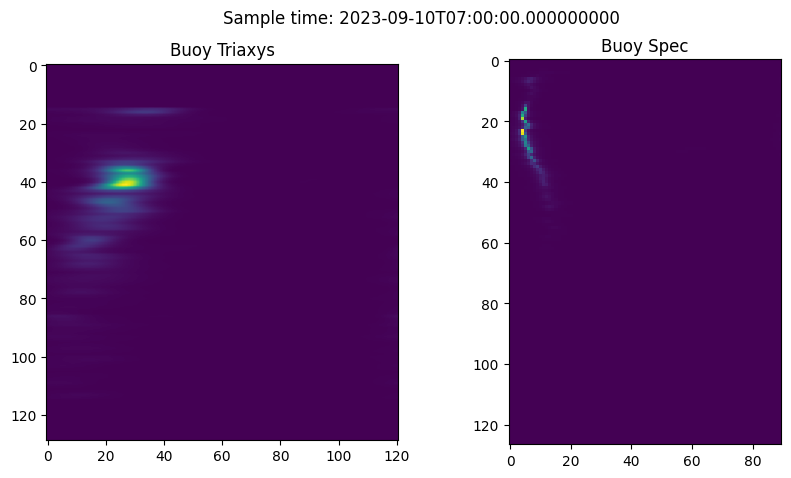

In [8]:
i = np.random.randint(X2d_1.shape[0])
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(X2d_2[i])
axs[0].set_title('Buoy Triaxys')
axs[1].imshow(X2d_1[i])
axs[1].set_title('Buoy Spec')
plt.suptitle(f'Sample time: {times[i]}')
plt.show()

In [11]:
X1d_1 = X2d_1.reshape((X2d_1.shape[0],-1))
X1d_2 = X2d_2.reshape((X2d_2.shape[0],-1))

In [13]:
pca_1 = PCA(n_components=100).fit(X1d_1)
pca_2 = PCA(n_components=100).fit(X1d_2)

Xpca_1 = pca_1.transform(X1d_1)
Xpca_2 = pca_2.transform(X1d_2)

X2d_1_r = pca_1.inverse_transform(Xpca_1).reshape(X2d_1.shape)
X2d_2_r = pca_2.inverse_transform(Xpca_2).reshape(X2d_2.shape)

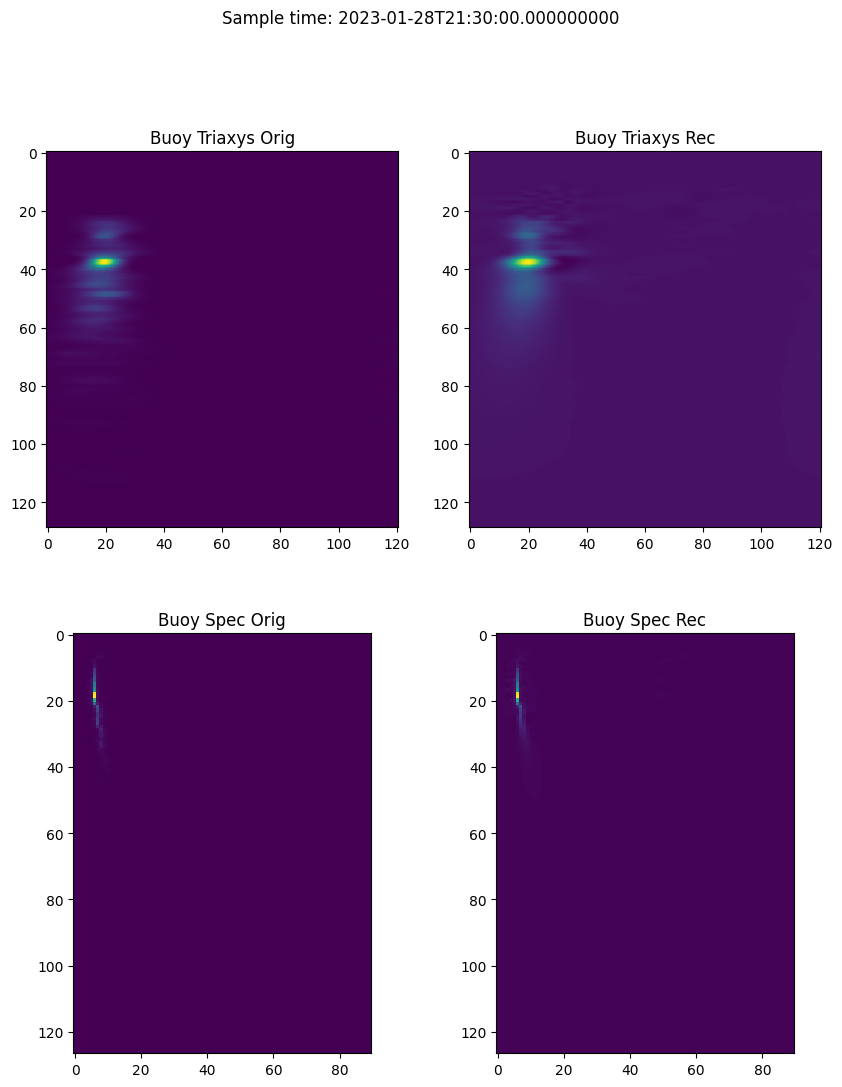

In [21]:
i = np.random.randint(X2d_1.shape[0])
fig, axs = plt.subplots(2,2,figsize=(10,12))
axs[0,0].imshow(X2d_2[i])
axs[0,0].set_title('Buoy Triaxys Orig')
axs[0,1].imshow(X2d_2_r[i])
axs[0,1].set_title('Buoy Triaxys Rec')
axs[1,0].imshow(X2d_1[i])
axs[1,0].set_title('Buoy Spec Orig')
axs[1,1].imshow(X2d_1_r[i])
axs[1,1].set_title('Buoy Spec Rec')
plt.suptitle(f'Sample time: {times[i]}')
plt.show()

In [23]:
class MLP(nn.Module):
    def __init__(self, input_dim=100, output_dim=100, hidden_dim=100):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [31]:
training_samples = 12_000
train_dataset = TensorDataset(torch.Tensor(Xpca_2[:training_samples]), torch.Tensor(Xpca_1[:training_samples]))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(Xpca_2[training_samples:]), torch.Tensor(Xpca_1[training_samples:]))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
model = MLP()
criterion = nn.MSELoss()  # Use appropriate loss function based on your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
model.train()
for epoch in range(epochs):
    running_loss = 0
    for batch_X, batch_Y in train_dataloader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        running_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/(len(train_dataloader)):.4f}")

Epoch 1/20, Loss: 0.0008
Epoch 2/20, Loss: 0.0006
Epoch 3/20, Loss: 0.0006
Epoch 4/20, Loss: 0.0005
Epoch 5/20, Loss: 0.0005
Epoch 6/20, Loss: 0.0005
Epoch 7/20, Loss: 0.0005
Epoch 8/20, Loss: 0.0005
Epoch 9/20, Loss: 0.0005
Epoch 10/20, Loss: 0.0005
Epoch 11/20, Loss: 0.0005
Epoch 12/20, Loss: 0.0004
Epoch 13/20, Loss: 0.0004
Epoch 14/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0004
Epoch 16/20, Loss: 0.0004
Epoch 17/20, Loss: 0.0004
Epoch 18/20, Loss: 0.0004
Epoch 19/20, Loss: 0.0004
Epoch 20/20, Loss: 0.0004


In [33]:
# Testing loop
model.eval()
running_loss = 0
for batch_X, batch_Y in test_dataloader:
    # Forward pass
    with torch.no_grad():
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        running_loss += loss.item()
print(f"Validation Loss: {running_loss/(len(test_dataloader)):.4f}")

Validation Loss: 0.0001


In [41]:
model(torch.tensor(Xpca_2[[i]]).float())

tensor([[-6.9522e-03, -4.1330e-02,  2.1049e-02, -6.6079e-02,  3.7862e-02,
          1.5868e-02, -7.4141e-04,  3.3991e-02,  5.6004e-02,  2.1170e-03,
         -4.1211e-02,  5.6723e-02, -7.6686e-05, -3.9858e-02,  2.0568e-02,
          1.7180e-02,  3.1509e-03,  2.7885e-02,  2.0061e-02, -9.7399e-03,
         -1.0230e-02, -4.8413e-03,  1.5202e-02,  1.0322e-02, -1.9617e-03,
         -1.8963e-02,  7.2485e-03,  4.7346e-03, -2.0314e-03,  5.8371e-03,
          4.7023e-04, -3.3805e-03,  1.6119e-03, -5.7370e-03, -1.1023e-03,
         -4.5353e-03,  2.3862e-03, -9.9910e-04, -1.6110e-03, -3.4351e-03,
         -9.0855e-04, -9.2112e-04, -3.7743e-04, -1.1317e-03, -4.1145e-03,
         -1.2051e-03,  2.1448e-03, -2.9822e-03, -6.8877e-04, -1.3681e-03,
          7.5978e-05, -3.9863e-03, -3.6098e-04,  7.3507e-04, -3.3257e-03,
          1.3677e-03, -2.7210e-04,  3.6871e-03,  3.9946e-04, -1.7198e-05,
         -3.0133e-03,  2.5494e-03, -4.5454e-04, -9.3922e-04,  1.5518e-03,
         -2.6519e-03, -6.5946e-04,  1.

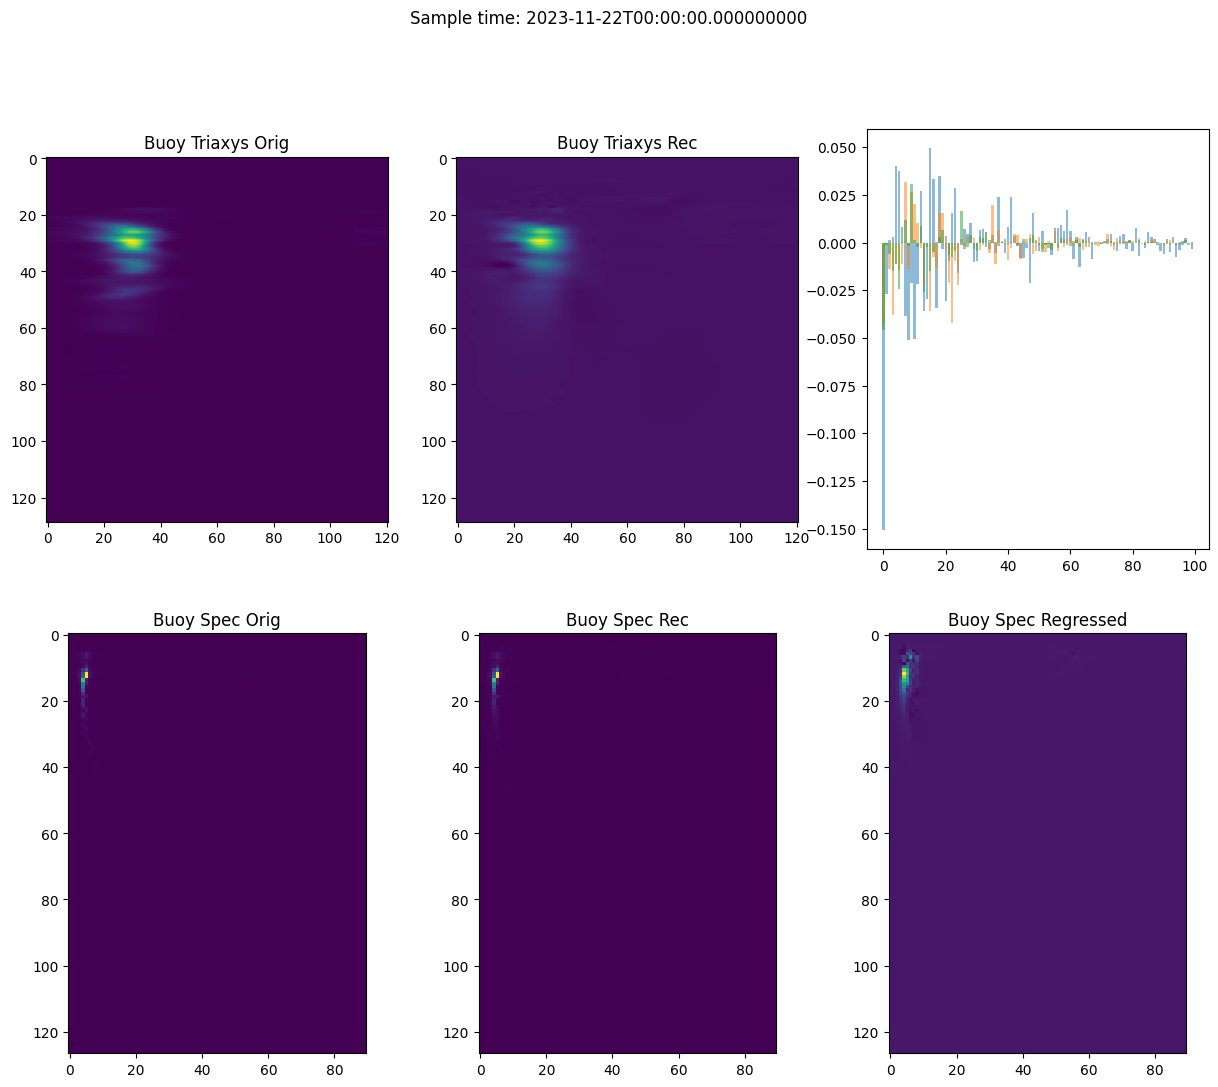

In [62]:
i = np.random.randint(X2d_1.shape[0])
fig, axs = plt.subplots(2,3,figsize=(15,12))
axs[0,0].imshow(X2d_2[i])
axs[0,0].set_title('Buoy Triaxys Orig')
axs[0,1].imshow(X2d_2_r[i])
axs[0,1].set_title('Buoy Triaxys Rec')
axs[1,0].imshow(X2d_1[i])
axs[1,0].set_title('Buoy Spec Orig')
axs[1,1].imshow(X2d_1_r[i])
axs[1,1].set_title('Buoy Spec Rec')

Xpca_1_pred = model(torch.tensor(Xpca_2[[i]]).float()).detach().numpy()
X1d_1_pred = pca_1.inverse_transform(Xpca_1_pred)[0]

axs[0,2].bar(np.arange(100), Xpca_2[i], alpha=0.5)
axs[0,2].bar(np.arange(100), Xpca_1[i], alpha=0.5)
axs[0,2].bar(np.arange(100), Xpca_1_pred[0], alpha=0.5)

axs[1,2].imshow(X1d_1_pred.reshape(X2d_1.shape[-2:]))
axs[1,2].set_title('Buoy Spec Regressed')

plt.suptitle(f'Sample time: {times[i]}')
plt.show()